<a href="https://colab.research.google.com/github/AyalSwaid/BookRecSys/blob/main/Copy_of_recSysNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download and unzip datasets

In [ ]:
with open("kaggle.json", "w") as file:
    file.write('{"username":"ayalsweed","key":"256c319bd85d5f872b0a7f47d2b522da"}')

!mkdir ../root/.kaggle
!cp kaggle.json ../root/.kaggle
!chmod 600 ../root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d arashnic/book-recommendation-dataset
!unzip -n "book-recommendation-dataset.zip"

 96% 23.0M/23.8M [00:00<00:00, 60.0MB/s]
100% 23.8M/23.8M [00:00<00:00, 60.2MB/s]
Archive:  book-recommendation-dataset.zip
  inflating: Books.csv               
  inflating: Ratings.csv             
  inflating: Users.csv               
  inflating: recsys_taxonomy2.png    


# imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# EDA

In [ ]:
# read datasets
ratings = pd.read_csv("Ratings.csv")
ratings = ratings.rename(columns = {'Book-Rating':'rating', 'User-ID': 'userID'})
users = pd.read_csv("Users.csv")
books = pd.read_csv("Books.csv")



<ipython-input-18-300aa37479f9>:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv("Books.csv")


In [ ]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   userID  1149780 non-null  int64 
 1   ISBN    1149780 non-null  object
 2   rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [ ]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


## Check ratings distributions

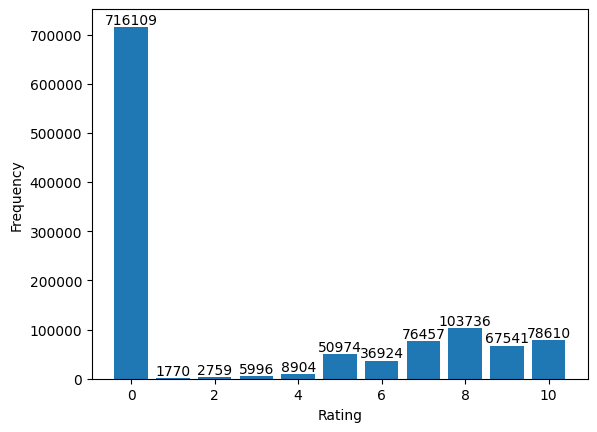

In [ ]:
def show_ratings_dist(df):
    rating_dist = df.groupby(['rating']).count().reset_index()
    # rating_dist
    # plt.bar(rating_dist["rating"].values,rating_dist["userID"])

    fig, ax = plt.subplots()
    bars = ax.bar(rating_dist["rating"].values, rating_dist["userID"])
    ax.set_xlabel("Rating")
    ax.set_ylabel("Frequency")
    ax.bar_label(bars)
show_ratings_dist(ratings)

normalize rating to max 5

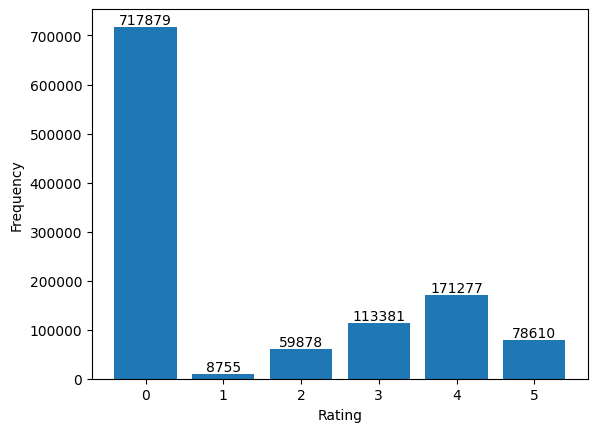

In [ ]:
# r = ratings.copy()
ratings["rating"] = ratings["rating"].apply(lambda e: e//2)
show_ratings_dist()

## build matrix factorization model



In [ ]:
!pip install scikit-surprise

In [ ]:
from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV

reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(ratings[['userID', 'ISBN', 'rating']], reader)

svd = SVD(n_epochs=30)
# cross_validate(model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)


param_grid = {'n_factors': [16, 32, 64],
              'lr_all': [0.01, 0.05]}

for nf in param_grid["n_factors"]:
    for ra in param_grid["lr_all"]:
        print(f"\n\nTrying n_factors={nf}, reg_all={ra}")
        cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=2, verbose=True)

# grid_search = GridSearchCV(svd, param_grid, measures=['rmse', 'mae'], cv=3)
# grid_search.fit(data)



Trying n_factors=16, reg_all=0.01
Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    3.5158  3.5133  3.5146  0.0013  
MAE (testset)     2.9962  2.9975  2.9969  0.0007  
Fit time          28.33   27.47   27.90   0.43    
Test time         7.22    7.17    7.19    0.02    


Trying n_factors=16, reg_all=0.05
Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    3.5151  3.5180  3.5166  0.0014  
MAE (testset)     2.9971  2.9993  2.9982  0.0011  
Fit time          28.79   27.94   28.36   0.42    
Test time         8.15    7.57    7.86    0.29    


Trying n_factors=32, reg_all=0.01
Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    3.5163  3.5149  3.5156  0.0007  
MAE (testset)     2.9983  2.9979  2.9981  0.0002  
Fit time          28.14   28.07   28.11   0.04    
Test time       